## Dataset COCO — Common Objects in Context

Прежде чем говорить о способах решения этих задач, надо разобраться с форматами входных данных. Сделаем это на примере датасета [COCO 🛠️[doc]](https://cocodataset.org/).

COCO — один из наиболее популярных датасатов, содержащий данные для сегментации и детектирования. Он содержит более трёхсот тысяч изображений, большая часть из которых размечена и содержит следующую информацию:
- категории;
- маски;
- ограничивающие боксы (*bounding boxes*);
- описания (*captions*);
- ключевые точки (*keypoints*);
- и многое другое.

Формат разметки изображений, использованный в этом датасете, нередко используется и в других наборах данных. Как правило, он упоминается просто как "COCO format".

Загрузим датасет:

In [1]:
# !wget -qN "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
!wget -qN "https://ml.gan4x4.ru/msu/datasets/annotations_trainval2017.zip"
!unzip -qn annotations_trainval2017.zip

Для работы с датасетом используется пакет `pycocotools`.

[[blog] ✏️ Как создать свой COCO датасет с нуля](https://www.immersivelimit.com/tutorials/create-coco-annotations-from-scratch)

In [2]:
from pycocotools.coco import COCO

coco = COCO("annotations/instances_val2017.json")

loading annotations into memory...
Done (t=1.70s)
creating index...
index created!


### Категории в COCO

Давайте посмотрим на категории в датасете.

In [3]:
cats = coco.loadCats(coco.getCatIds())  # loading categories
num2cat = {}
print("COCO categories: ")

iterator = iter(cats)
cat = next(iterator)
for i in range(0, 91):
    if i == cat["id"]:
        num2cat[cat["id"]] = cat["name"]
        name = cat["name"]
        if i < 90:
            cat = next(iterator)
    else:
        name = "---"

    print(f"{i:2}. {name:20}", end="")

    if not i % 6:
        print("\n")

COCO categories: 
 0. ---                 

 1. person               2. bicycle              3. car                  4. motorcycle           5. airplane             6. bus                 

 7. train                8. truck                9. boat                10. traffic light       11. fire hydrant        12. ---                 

13. stop sign           14. parking meter       15. bench               16. bird                17. cat                 18. dog                 

19. horse               20. sheep               21. cow                 22. elephant            23. bear                24. zebra               

25. giraffe             26. ---                 27. backpack            28. umbrella            29. ---                 30. ---                 

31. handbag             32. tie                 33. suitcase            34. frisbee             35. skis                36. snowboard           

37. sports ball         38. kite                39. baseball bat        40. base

Категория **0** используется для обозначения класса фона. Некоторые номера категорий не заняты.

Также существуют надкатегории.

In [4]:
print(f"categories[2]: {cats[2]}")
print(f"categories[3]: {cats[3]}")

nms = set([cat["supercategory"] for cat in cats])
print("COCO supercategories: \n{}".format("\t".join(nms)))

categories[2]: {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}
categories[3]: {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}
COCO supercategories: 
kitchen	electronic	food	outdoor	accessory	person	vehicle	animal	sports	appliance	furniture	indoor


### Разметка данных

Рассмотрим формат аннотаций на примере одной записи:

In [5]:
catIds = coco.getCatIds(catNms=["cat"])  #  Find category ID by tag
print("class ID(cat) =", catIds)

imgIds = coco.getImgIds(catIds=catIds)  # Filtering dataset by category ID
print("All images: %i" % len(imgIds))

class ID(cat) = [17]
All images: 184


Рассмотрим метаданные для первого изображения из категории:

In [6]:
img_list = coco.loadImgs(imgIds[0])  # 1 example
img_metadata = img_list[0]
img_metadata

{'license': 5,
 'file_name': '000000416256.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000416256.jpg',
 'height': 375,
 'width': 500,
 'date_captured': '2013-11-18 04:05:18',
 'flickr_url': 'http://farm1.staticflickr.com/34/64280333_7acf38cfb3_z.jpg',
 'id': 416256}

Посмотрим на изображение.

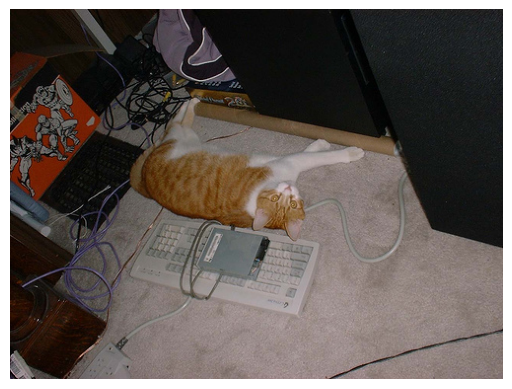

In [7]:
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO


def coco2pil(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content))


I = coco2pil(img_metadata["coco_url"])
plt.axis("off")
plt.imshow(I)
plt.show()

Помимо метаданных нам доступна [разметка 🛠️[doc]](https://cocodataset.org/#format-data). Давайте её загрузим и отобразим.

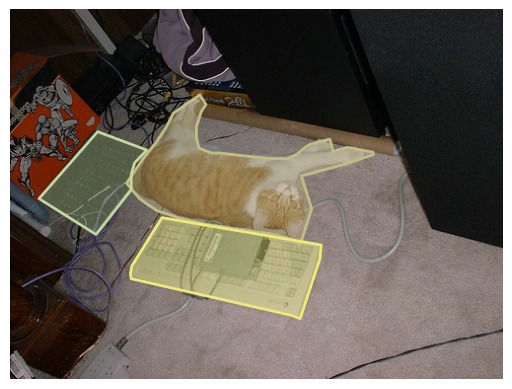

In [8]:
annIds = coco.getAnnIds(imgIds=img_metadata["id"])
anns = coco.loadAnns(annIds)

plt.imshow(I)
plt.axis("off")
coco.showAnns(anns)
plt.show()

На изображении можно увидеть разметку пикселей изображения по классам. То есть пиксели из объектов, относящихся к интересующим классам, приписываются к классу этого объекта. К примеру, можно увидеть объекты двух классов: "cat" и "keyboard".

Давайте теперь посмотрим, из чего состоит разметка.

In [9]:
def dump_anns(anns):
    for i, a in enumerate(anns):
        print(f"\n#{i}")
        for k in a.keys():
            if k == "category_id" and num2cat.get(a[k], None):
                print(k, ": ", a[k], num2cat[a[k]])  # Show cat. name
            else:
                print(k, ": ", a[k])


dump_anns(anns)


#0
segmentation :  [[157.26, 120.16, 165.32, 104.84, 191.94, 86.29, 198.39, 95.97, 193.55, 103.23, 188.71, 118.55, 188.71, 130.65, 191.13, 140.32, 204.03, 145.16, 211.29, 145.16, 262.1, 150.81, 280.65, 150.81, 290.32, 146.77, 300.0, 138.71, 304.03, 136.29, 322.58, 131.45, 324.19, 131.45, 327.42, 143.55, 341.94, 139.52, 367.74, 144.35, 368.55, 146.77, 337.1, 157.26, 312.9, 163.71, 295.16, 168.55, 299.19, 181.45, 305.65, 201.61, 293.55, 239.52, 288.71, 233.87, 265.32, 227.42, 225.0, 221.77, 199.19, 217.74, 170.97, 211.29, 159.68, 207.26, 149.19, 204.03, 137.1, 195.97, 130.65, 191.13, 117.74, 175.81, 134.68, 150.81, 147.58, 134.68]]
area :  15465.184599999999
iscrowd :  0
image_id :  416256
bbox :  [117.74, 86.29, 250.81, 153.23]
category_id :  17 cat
id :  51846

#1
segmentation :  [[122.48, 272.75, 284.67, 309.77, 293.93, 313.33, 313.86, 252.82, 315.29, 238.58, 153.67, 210.81, 123.06, 259.93, 121.64, 267.77]]
area :  12449.917949999995
iscrowd :  0
image_id :  416256
bbox :  [121.64, 2

Заметим, что аннотация изображения может состоять из описаний нескольких объектов, каждое из которых содержит следующую информацию:
* `segmentation` — последовательность пар чисел ($x$, $y$) — координат каждой из вершин "оболочки" объекта;
* `area` — площадь объекта;
* `iscrowd` — несколько объектов, например, толпа людей, в этом случае информация о границах объекта (маска) хранится в формате [RLE 📚[wiki]](https://en.wikipedia.org/wiki/Run-length_encoding);
* `image_id` — идентификатор изображения, к которому принадлежит описываемый объект;
* `bbox` — ограничивающий прямоугольник,*будет рассмотрен далее в ходе лекции*;
* `category_id` — идентификатор категории, к которой относится данный объект;
* `id` — идентификатор самого объекта.

Попробуем посмотреть на пример, в котором `iscrowd = True`.


#0
segmentation :  {'counts': [272, 2, 4, 4, 4, 4, 2, 9, 1, 2, 16, 43, 143, 24, 5, 8, 16, 44, 141, 25, 8, 5, 17, 44, 140, 26, 10, 2, 17, 45, 129, 4, 5, 27, 24, 5, 1, 45, 127, 38, 23, 52, 125, 40, 22, 53, 123, 43, 20, 54, 122, 46, 18, 54, 121, 54, 12, 53, 119, 57, 11, 53, 117, 59, 13, 51, 117, 59, 13, 51, 117, 60, 11, 52, 117, 60, 10, 52, 118, 60, 9, 53, 118, 61, 8, 52, 119, 62, 7, 52, 119, 64, 1, 2, 2, 51, 120, 120, 120, 101, 139, 98, 142, 96, 144, 93, 147, 90, 150, 87, 153, 85, 155, 82, 158, 76, 164, 66, 174, 61, 179, 57, 183, 54, 186, 52, 188, 49, 191, 47, 193, 21, 8, 16, 195, 20, 13, 8, 199, 18, 222, 17, 223, 16, 224, 16, 224, 15, 225, 15, 225, 15, 225, 15, 225, 15, 225, 15, 225, 15, 225, 15, 225, 15, 225, 14, 226, 14, 226, 14, 39, 1, 186, 14, 39, 3, 184, 14, 39, 4, 183, 13, 40, 6, 181, 14, 39, 7, 180, 14, 39, 9, 178, 14, 39, 10, 177, 14, 39, 11, 176, 14, 38, 14, 174, 14, 36, 19, 171, 15, 33, 32, 160, 16, 30, 35, 159, 18, 26, 38, 158, 19, 23, 41, 157, 20, 19, 45, 156, 21, 15, 48, 1

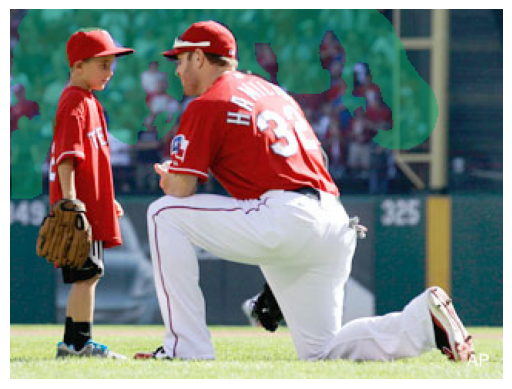

In [10]:
catIds = coco.getCatIds(catNms=["people"])
annIds = coco.getAnnIds(catIds=catIds, iscrowd=True)
anns = coco.loadAnns(annIds[0:1])

dump_anns(anns)
img = coco.loadImgs(anns[0]["image_id"])[0]
I = coco2pil(img["coco_url"])
plt.imshow(I)
coco.showAnns(anns)  # People in the stands
seg = anns[0]["segmentation"]
print("Counts", len(seg["counts"]))
print("Size", seg["size"])
plt.axis("off")
plt.show()

[[video] 📺 COCO Dataset Format — Complete Walkthrough](https://www.youtube.com/watch?v=h6s61a_pqfM)

#### Mask

Используя методы из `pycocotools`, можно  преобразовать набор вершин "оболочки" сегментируемого объекта в более удобный, но менее компактный вид — маску объекта.

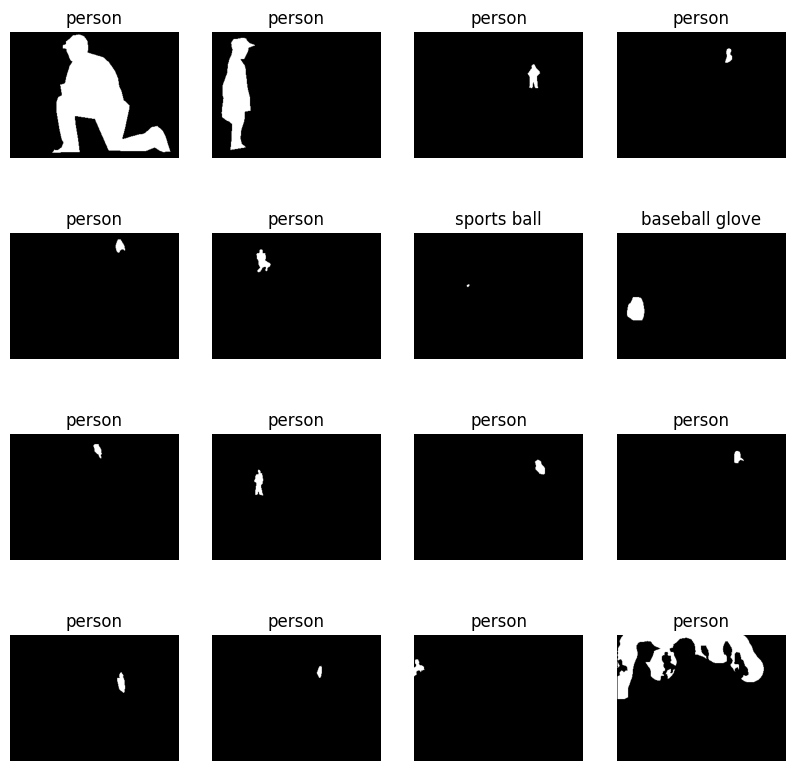

In [11]:
import numpy as np

annIds = coco.getAnnIds(imgIds=[448263])
anns = coco.loadAnns(annIds)
msk = np.zeros(I.size)

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))


i = 0
for row in range(4):
    for col in range(4):
        ann = anns[i]
        msk = coco.annToMask(ann) # poly -> binary mask
        ax[row, col].imshow(msk, cmap="gray")
        ax[row, col].set_title(num2cat[anns[i]["category_id"]])
        ax[row, col].axis("off")
        i += 1

plt.show()

#### Bounding box
В некоторых случаях попиксельная разметка изображения может быть избыточной. К примеру, если необходимо посчитать количество человек на изображении, то достаточно просто каким-то образом промаркировать каждого из них, после чего посчитать количество наших "отметок". Одним из вариантов маркировки является "обведение" объекта рамкой (bounding box), внутри которой он находится. Такая информация об объектах также сохранена в аннотациях формата COCO.

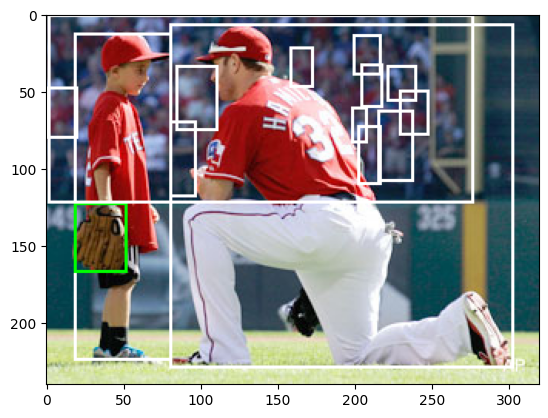

In [12]:
from PIL import ImageDraw

annIds = coco.getAnnIds(imgIds=[448263])
anns = coco.loadAnns(annIds)
draw = ImageDraw.Draw(I)

colors = {1: "white", 40: "lime"}  # person - white, glove - lime
for ann in anns:
    x, y, width, heigth = ann["bbox"]  # bounding box here
    color = colors.get(ann["category_id"], None)
    if color:
        draw.rectangle((x, y, x + width, y + heigth), outline=color, width=2)
plt.imshow(I)
plt.show()